In [101]:
import tensorflow as tf
from tensorflow.keras.models import Model
import numpy as np

In [102]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras import optimizers
from pandas import Series
import math
import numpy
from tensorflow.keras.layers import *
from tensorflow.keras import layers
import pandas as pd

#data = pd.read_csv('bitcoin.csv')
data = pd.read_csv('https://raw.githubusercontent.com/ikwak2/hj19_timeseries/main/btc/bitcoin2000.csv?token=ATB7FV4BSDYDQWJVQOJY2C3BMRBN6')

In [103]:
def gradient_importance(seq, model):

    seq = tf.Variable(seq[np.newaxis,:,:], dtype=tf.float32)

    with tf.GradientTape() as tape:
        predictions = model(seq)

    grads = tape.gradient(predictions, seq)
    grads = tf.reduce_mean(grads, axis=1).numpy()[0]
    
    return grads

def gradient_weight(seq, model):

    seq = tf.Variable(seq[np.newaxis,:,:], dtype=tf.float32)

    with tf.GradientTape() as tape:
        predictions = model(seq)

    grad = tape.gradient(predictions, seq)
    #gr=grads
    #grads = tf.reduce_mean(grads, axis=1).numpy()[0]
    
    return grad


def activation_grad(seq, model):
    
    seq = seq[np.newaxis,:,:]
    grad_model = Model([model.inputs], 
                       [model.get_layer('extractor').output, 
                        model.output])

    # Obtain the predicted value and the intermediate filters
    with tf.GradientTape() as tape:
        seq_outputs, predictions = grad_model(seq)

    # Extract filters and gradients
    output = seq_outputs[0]
    grads = tape.gradient(predictions, seq_outputs)[0]

    # Average gradients spatially
    weights = tf.reduce_mean(grads, axis=0)
    
    # Get a ponderated map of filters according to grad importance
    cam = np.ones(output.shape[0], dtype=np.float32)
    for index, w in enumerate(weights):
        cam += w * output[:, index]

    time = int(seq.shape[1]/output.shape[0])
    cam = zoom(cam.numpy(), time, order=1)
    heatmap = (cam - cam.min())/(cam.max() - cam.min())
    
    return heatmap

In [104]:
data

,time,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol,timeUTC
0,1576144800,7219.93,7149.15,7170.18,1536.79,1.104199e+07,7166.14,direct,NaN,2019-12-12 19:00:00
1,1576148400,7208.36,7166.03,7166.14,785.11,5.654607e+06,7199.79,direct,NaN,2019-12-12 20:00:00
2,1576152000,7222.43,7194.87,7199.79,672.46,4.855213e+06,7199.97,direct,NaN,2019-12-12 21:00:00
3,1576155600,7211.80,7187.29,7199.97,807.61,5.821088e+06,7201.38,direct,NaN,2019-12-12 22:00:00
4,1576159200,7229.22,7152.84,7201.38,1606.06,1.153780e+07,7173.50,direct,NaN,2019-12-12 23:00:00
5,1576162800,7202.12,7162.03,7173.50,856.09,6.141961e+06,7202.12,direct,NaN,2019-12-13 00:00:00
6,1576166400,7225.83,7192.73,7202.12,1376.21,9.922530e+06,7212.33,direct,NaN,2019-12-13 01:00:00
7,1576170000,7222.08,7200.95,7212.33,586.49,4.235649e+06,7213.47,direct,NaN,2019-12-13 02:00:00
8,1576173600,7234.95,7200.95,7213.47,1353.88,9.767061e+06,7224.86,direct,NaN,2019-12-13 03:00:00
9,1576177200,7231.08,7208.79,7224.86,870.00,6.278417e+06,7218.46,direct,NaN,2019-12-13 04:00:00


In [105]:
'''
from sklearn.preprocessing import MinMaxScaler
values = data[['close','high','low','open','volumefrom','volumeto']].values.reshape(-1,6)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values) '''

"\nfrom sklearn.preprocessing import MinMaxScaler\nvalues = data[['close','high','low','open','volumefrom','volumeto']].values.reshape(-1,6)\nvalues = values.astype('float32')\nscaler = MinMaxScaler(feature_range=(0, 1))\nscaled = scaler.fit_transform(values) "

In [106]:
from sklearn.preprocessing import MinMaxScaler
values = data[['close','high','low','open','volumefrom','volumeto']].values.reshape(-1,6)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled=scaler.fit_transform(values)
#scaled = (values-(np.min(values)))/(np.max(values)-(np.min(values)))
#scaled = (values - np.mean(values))/np.std(values) 

In [107]:
np.max(values)

7859574300.0

In [108]:
np.min(values)

161.86

In [109]:
np.max(values)-np.min(values)

7859574300.0

In [110]:
scaled

array([[8.e-02, 7.e-02, 9.e-02, 8.e-02, 6.e-03, 1.e-03],
       [8.e-02, 7.e-02, 9.e-02, 8.e-02, 3.e-03, 6.e-04],
       [8.e-02, 7.e-02, 9.e-02, 8.e-02, 2.e-03, 5.e-04],
       ...,
       [8.e-01, 8.e-01, 8.e-01, 8.e-01, 5.e-03, 6.e-03],
       [8.e-01, 8.e-01, 8.e-01, 8.e-01, 4.e-03, 5.e-03],
       [8.e-01, 8.e-01, 8.e-01, 8.e-01, 2.e-03, 2.e-03]], dtype=float32)

In [111]:

train_size = int(len(scaled) * 0.80)
val_size = int(len(scaled) * 0.10)

test_size = len(scaled) - train_size-val_size
train,val, test = scaled[0:train_size,:],scaled[train_size:train_size+val_size,:], scaled[train_size+val_size:,:]
print(len(train),len(val), len(test))

8004 1000 1001


In [112]:
def create_dataset_multistep(dataset, look_back=1,predict=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back-predict):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i+ look_back-1: i+ look_back+predict-1, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [113]:
look_back = 168
predict=24
trainX, trainY = create_dataset_multistep(train, look_back,predict)
valX, valY = create_dataset_multistep(val, look_back,predict)
testX, testY = create_dataset_multistep(test, look_back,predict)

7812
808
809


In [114]:
testX

array([[[1., 0., 1., 0., 0., 0.],
        [1., 0., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        ...,
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0., 0.]],

       [[1., 0., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [0., 0., 1., 1., 0., 0.],
        ...,
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0., 0.]],

       [[1., 1., 1., 1., 0., 0.],
        [0., 0., 1., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        ...,
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0., 0.]],

       ...,

       [[1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        ...,
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0., 0.]],

       [[1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        .

In [115]:

print(trainX.shape)
print(trainY.shape)

(7812, 168, 6)
(7812, 24)


In [116]:
SMALL_SIZE = 20
MEDIUM_SIZE = 23
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE) # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE) # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE) # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE) # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE) # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE) # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE) # fontsize of the figure title

CNN-LSTM

In [117]:
from tensorflow.keras.models import Model

first_input = Input(shape=(168,6))

in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
in1=MaxPooling1D(pool_size=2, name='extractor')(in1)
#in1=Dropout(0.5)(in1)
#in1=Flatten()(in1)
#in1=Dense(100, activation='relu')(in1)
in1=LSTM(100)(in1)
in1=Dense(100)(in1)
in1=Dropout(0.5)(in1)
out=Dense(24)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

checkpoint_path = "saved_weights/btc_cnnlstm_multistep.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

In [118]:
model.load_weights("saved_weights/btc_cnnlstm_multistep.hdf5")

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]


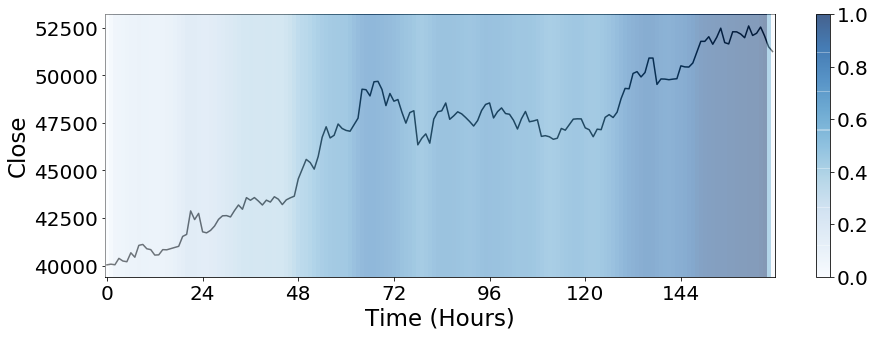

In [119]:
from scipy.ndimage import zoom
import random
import pylab

X_test=testX.copy()
id_=24*3
testX_inverse=X_test[id_][:,0]*(np.max(values)-np.min(values))+np.min(values)
testX_inverse

X_test=testX.copy()
activation = activation_grad(X_test[id_], model)
print(activation)
fig, ax = plt.subplots(1,1, figsize=(15,5))
ax.set_xticks([0,24,48,72,96,120,144,168])
plt.rc('font', size=20)

plt.plot(testX_inverse/100000, 'k')
plt.ylabel('Close'); plt.xlabel('Time (Hours)'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
plt.twinx()
#plt.xticks(a)
plt.imshow(np.vstack([activation]*120), alpha=0.5, cmap='Blues')
plt.axis('off'); 
plt.colorbar()
plt.axis('off')
#pylab.pcolor(np.vstack([activation]*120),cmap='jet',alpha=0.35)
plt.subplots_adjust(bottom=0.15)

#pylab.colorbar()

np.set_printoptions(False)

plt.savefig('png/btc_grad cam_cnn-lstm.png', dpi=300)

1.0
0.0
1.0
(1, 168, 6)


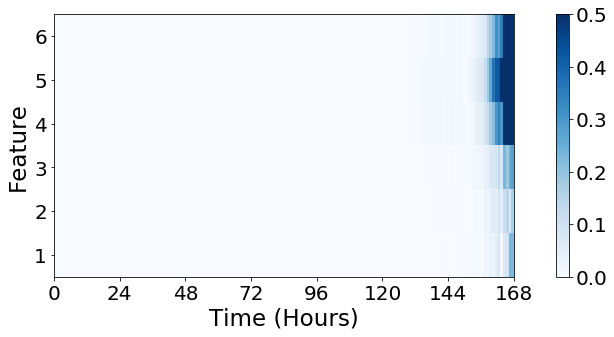

In [120]:
import matplotlib.pyplot as plt
import numpy as np

X_test=testX
grad_weight = gradient_weight(X_test[id_], model)

grad_weight_abs = abs(grad_weight)

grad_weight_abs_z = (grad_weight_abs-(np.min(grad_weight_abs)))/(np.max(grad_weight_abs)-(np.min(grad_weight_abs)))

print(np.max(grad_weight_abs_z))
print(np.min(grad_weight_abs_z))
print(np.max(grad_weight_abs_z)-np.min(grad_weight_abs_z))
#grad_weight=grad_weight.reshape(48,4)

print(grad_weight_abs_z.shape)

#plt.plot(X_test[8], 'k')
a=grad_weight_abs_z.numpy()
a=a.reshape(168,6)
a=a.transpose()
#print(a)
fig, ax = plt.subplots(1,1, figsize=(15,5))

y_label_list = [1,2,3,4,5,6]
x_label_list = [0,24,48,72,96,120,144,168]
ax.set_xticks([0,24,48,72,96,120,144,168])

ax.set_yticks([8,24,40,56,72,88])

ax.set_yticklabels(y_label_list)
ax.set_xticklabels(x_label_list)

ax.set_yticklabels(y_label_list)
ax.set_xticklabels(x_label_list)
ax.set_xlabel('Time (Hours)')
ax.set_ylabel('Feature')
plt.subplots_adjust(bottom=0.15)

plt.imshow(a,extent = [0 , 168, 0 , 96], vmin=0, vmax=0.5, cmap="Blues", interpolation='nearest')
plt.colorbar()

plt.savefig('png/btc_feature importance_cnn-lstm(1).png')

LSTM-CNN

In [121]:
from tensorflow.keras.models import Model

first_input = Input(shape=(168,6))

in0=LSTM(64,return_sequences=True)(first_input)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([in0,in1],name='extractor1')

#ad=Dropout(0.5)(ad)
#in0=LSTM(64,return_sequences=True)(ad)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=Flatten()(in1)
in1=Dense(100, activation='relu')(in1)

in1=Dropout(0.5)(in1)
out=Dense(24,'relu')(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

checkpoint_path = "saved_weights/btc_lstmcnn_mulstep.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)


In [122]:
model.load_weights("saved_weights/btc_lstmcnn_mulstep.hdf5")

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.]


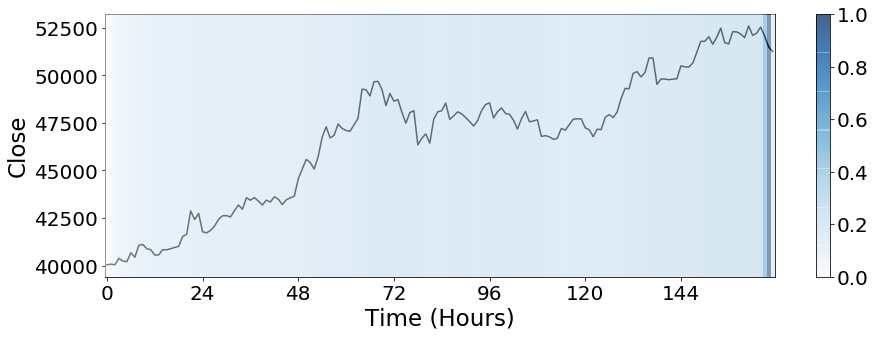

In [123]:
from scipy.ndimage import zoom
import random
import pylab

X_test=testX.copy()
id_=24*3
testX_inverse=X_test[id_][:,0]*(np.max(values)-np.min(values))+np.min(values)
testX_inverse

X_test=testX.copy()
activation = activation_grad(X_test[id_], model)
print(activation)
fig, ax = plt.subplots(1,1, figsize=(15,5))
ax.set_xticks([0,24,48,72,96,120,144,168])

plt.plot(testX_inverse/100000, 'k')
plt.ylabel('Close'); plt.xlabel('Time (Hours)'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
plt.twinx()
#plt.xticks(a)
plt.imshow(np.vstack([activation]*120), alpha=0.5, cmap='Blues')
plt.axis('off'); 
plt.colorbar()
plt.axis('off')
#pylab.pcolor(np.vstack([activation]*120),cmap='jet',alpha=0.35)
plt.subplots_adjust(bottom=0.15)

#pylab.colorbar()

np.set_printoptions(False)

plt.savefig('png/btc_grad cam_lstm-cnn.png', dpi=300)

1.0
0.0
1.0
(1, 168, 6)


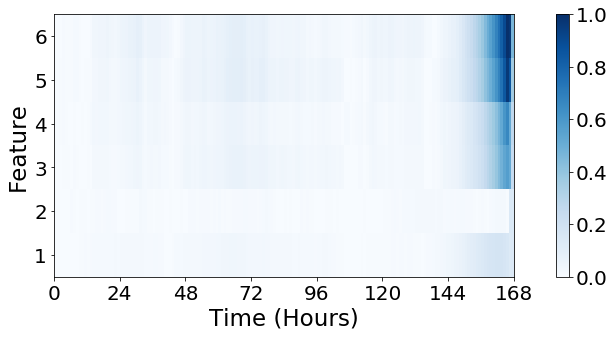

In [124]:
import matplotlib.pyplot as plt
import numpy as np

X_test=testX
grad_weight = gradient_weight(X_test[id_], model)

grad_weight_abs = abs(grad_weight)

grad_weight_abs_z = (grad_weight_abs-(np.min(grad_weight_abs)))/(np.max(grad_weight_abs)-(np.min(grad_weight_abs)))

print(np.max(grad_weight_abs_z))
print(np.min(grad_weight_abs_z))
print(np.max(grad_weight_abs_z)-np.min(grad_weight_abs_z))
#grad_weight=grad_weight.reshape(48,4)

print(grad_weight_abs_z.shape)

#plt.plot(X_test[8], 'k')
a=grad_weight_abs_z.numpy()
a=a.reshape(168,6)
a=a.transpose()
#print(a)
fig, ax = plt.subplots(1,1, figsize=(15,5))
plt.subplots_adjust(bottom=0.15)

y_label_list = [1,2,3,4,5,6]
x_label_list = [0,24,48,72,96,120,144,168]
ax.set_xticks([0,24,48,72,96,120,144,168])

ax.set_yticks([8,24,40,56,72,88])

ax.set_yticklabels(y_label_list)
ax.set_xticklabels(x_label_list)

ax.set_yticklabels(y_label_list)
ax.set_xticklabels(x_label_list)
ax.set_xlabel('Time (Hours)')
ax.set_ylabel('Feature')

plt.imshow(a,extent = [0 , 168, 0 , 96], vmin=0, vmax=1, cmap="Blues", interpolation='nearest')
plt.colorbar()

plt.savefig('png/btc_feature importance_lstm-cnn(1).png')

LSTM-resCNN




In [125]:
from tensorflow.keras.models import Model

first_input = Input(shape=(168,6))

in0=LSTM(64,return_sequences=True)(first_input)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1],name='extractor1')

#ad=Dropout(0.5)(ad)
#in0=LSTM(64,return_sequences=True)(ad)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1],name='extractor')


in1=Flatten()(in1)
in1=Dense(100, activation='relu')(in1)
in1=Dropout(0.5)(in1)

out=Dense(24,'relu')(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

checkpoint_path = "saved_weights/btc_lstmrescnn_mulstep.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

In [126]:
model.load_weights("saved_weights/btc_lstmrescnn_mulstep.hdf5")

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]


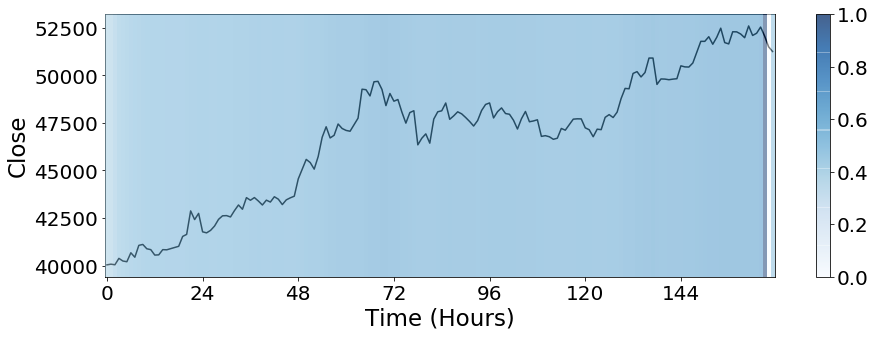

In [127]:

X_test=testX.copy()
id_=24*3
testX_inverse=X_test[id_][:,0]*(np.max(values)-np.min(values))+np.min(values)
testX_inverse

X_test=testX.copy()
activation = activation_grad(X_test[id_], model)
print(activation)
fig, ax = plt.subplots(1,1, figsize=(15,5))
ax.set_xticks([0,24,48,72,96,120,144,168])

plt.plot(testX_inverse/100000, 'k')
plt.ylabel('Close'); plt.xlabel('Time (Hours)'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
plt.twinx()
#plt.xticks(a)
plt.imshow(np.vstack([activation]*120), alpha=0.5, cmap='Blues')
plt.axis('off'); 
plt.colorbar()
plt.axis('off')
#pylab.pcolor(np.vstack([activation]*120),cmap='jet',alpha=0.35)
plt.subplots_adjust(bottom=0.15)

#pylab.colorbar()

np.set_printoptions(False)

plt.savefig('png/btc_grad cam_lstm-rescnn.png', dpi=300)

1.0
0.0
1.0
(1, 168, 6)


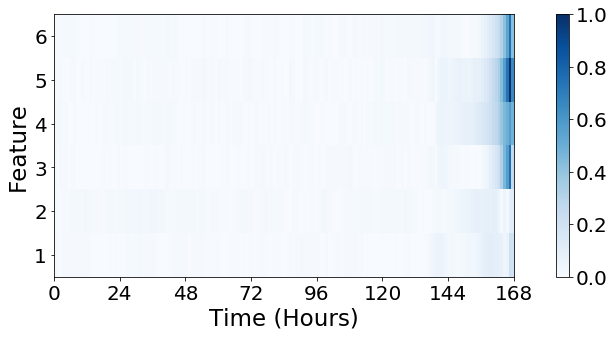

In [128]:
import matplotlib.pyplot as plt
import numpy as np

X_test=testX
grad_weight = gradient_weight(X_test[id_], model)

grad_weight_abs = abs(grad_weight)

grad_weight_abs_z = (grad_weight_abs-(np.min(grad_weight_abs)))/(np.max(grad_weight_abs)-(np.min(grad_weight_abs)))

print(np.max(grad_weight_abs_z))
print(np.min(grad_weight_abs_z))
print(np.max(grad_weight_abs_z)-np.min(grad_weight_abs_z))
#grad_weight=grad_weight.reshape(48,4)

print(grad_weight_abs_z.shape)

#plt.plot(X_test[8], 'k')
a=grad_weight_abs_z.numpy()
a=a.reshape(168,6)
a=a.transpose()
#print(a)
fig, ax = plt.subplots(1,1, figsize=(15,5))
#plt.rc('font', size=12)

y_label_list = [1,2,3,4,5,6]
x_label_list = [0,24,48,72,96,120,144,168]
ax.set_xticks([0,24,48,72,96,120,144,168])

ax.set_yticks([8,24,40,56,72,88])

ax.set_yticklabels(y_label_list)
ax.set_xticklabels(x_label_list)
ax.set_xlabel('Time (Hours)')
ax.set_ylabel('Feature')
plt.subplots_adjust(bottom=0.15)

plt.imshow(a,extent = [0 , 168, 0 , 96], vmin=0, vmax=1, cmap="Blues", interpolation='nearest')
plt.colorbar()

plt.savefig('png/btc_feature importance_lstm-rescnn(1).png')